In [14]:
import os
from PIL import Image
from numpy import asarray
import numpy as np
import sys
from sklearn.metrics import accuracy_score
from sklearn.utils import Bunch
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_curve,auc,accuracy_score,classification_report 
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

In [15]:
#helper function to convert images into numpy arrays
#External reference used https://pillow.readthedocs.io/en/3.1.x/reference/Image.html

def readInput(folderList):
    #setting height and width of the images
    width = 100
    height = 100
    
    #setting the print option for numpy array
    np.set_printoptions(threshold=sys.maxsize)
    
    #setting path variable to store the folder path of images folder
    npath =  os.getcwd() + '\Dataset'
    
    #creating empty numpy arrays to store dependednt and independent variables
    X = np.empty((80,10000))
    yfinal = np.empty((80,1))
    
    #used to store lables of the images
    labelList = []
    
    images_data = []
    
    #setting path variable to store the folder path of images available in the first folder
    strPath = npath + '\\' + folderList[0]   + '\\'
    
    #iterate over the path of image folder,open the image file,convert into grayscale format and setting the image height and width
    # r=root, d=directories, f = files
    for r, d, f in os.walk(strPath):
        for file in f:
            image = Image.open(r+file)
            image = image.convert(mode = 'L')
            image = image.resize((width,height))

            #converting the image varibale value into an array
            data = asarray(image)
            #collapsing the data variable value into one dimension
            data = data.flatten()
            #append the data variable value into images_data list
            images_data.append(data)
            #storing  images label in a list
            labelList.append(folderList[0])

    
    

    #creating numpy array from the images_data list
    images = np.array(images_data)
    
    # creating a new array y of given shape and type and filled with fill value as image label
    y = np.full((20,),folderList[0])
    
    #process completed for the images available in the first folder
    
    
    #creating an empty list to store the values for second fruit images
    images_data2 = []
    
    
    #setting path variable to store the folder path of images available in the second folder
    strPath = npath  + '\\' + folderList[1] + '\\'
    
    #iterate over the path of image folder,open the image file,convert into grayscale format and setting the image height and width
    # r=root, d=directories, f = files
    for r, d, f in os.walk(strPath):
        for file in f:
            image = Image.open(r+file)
            image = image.convert(mode = 'L')
            image = image.resize((width,height))

            #converting the image varibale value into an array
            data = asarray(image)
            #collapsing the data variable value into one dimension
            data = data.flatten()
            #append the data variable value into images_data2 list
            images_data2.append(data)
            #storing  images label in a list
            labelList.append(folderList[1])


    # creating numpy array from the images_data list
    images2 = np.array(images_data2)

    # creating a new array y of given shape and type and filled with fill value as image label
    y2 = np.full((20,),folderList[1])

    #Stacking images and images2 arrays in sequence vertically (row wise) and storing the result in images_final.
    images_final = np.vstack((images,images2))
    
    #Stacking y and y2 arrays in sequence horizontally (column wise) and storing the result in y_final.Both y and y2 are 1d array
    y_final = np.hstack((y,y2))

    #storing images_final and y_final value in X and y respectively
    X = images_final
    y = y_final
    
    #looping through remaining folders list
    #and converting individual folder's images into grayscale format and setting their height and width
    for i in range(2,len(folderList)):
    
        #setting path variable to store the folder path of images available in the remaining folders
        path = npath + '\\' + folderList[i]  + '\\'
        
        #creating an empty list to store the values for remaining fruit images
        images_data = []
        
        #iterate over the path of image folder and open the image file,convert the image file into grayscale format and setting the image height and width
        # r=root, d=directories, f = files
        for r, d, f in os.walk(path):
            for file in f:
                image = Image.open(r+file)
                image = image.convert(mode = 'L')
                image = image.resize((width,height))

                #converting the image varibale value into an array
                data = asarray(image)
                #collapsing the data variable value into one dimension
                data = data.flatten()
                #append the data variable value into images_data list
                images_data.append(data)
                #storing  images label in a list
                labelList.append(folderList[i])
        
        #creating numpy array from the images_data list
        images2 = np.array(images_data)
        
        #creating a new array y of given shape and type and filled with fill value as image label
        y2 = np.full((20,),folderList[i])
        
        #Stacking images and images2 arrays in sequence vertically (row wise) and storing the result in images_final
        images_final = np.vstack((images_final,images2))
        
        #Stacking y and y2 arrays in sequence horizontally (column wise) and storing the result in y_final.Both y and y2 are 1d array
        y_final = np.hstack((y_final,y2))
    
    #storing images_final and y_final value in X and Y respectively
    X = images_final
    #resizing the Y array to the shape of X
    Y = y_final.reshape(80,1)
    #resizing the labels array to the shape of X
    labels = np.array(labelList).reshape(80,1)  
    return (X,Y,labels)

In [16]:
#list to store different image type
list_folderList = ['oranges','avacado','pineapple','strawberries']

#storing return values from readInput into variables X,y and labels
X,y,labels = readInput(list_folderList)

In [6]:
#using PCA to reduce dimension of dataset X
pca = PCA(n_components=20, whiten=True, random_state=0)

#fit the PCA model on X and apply the dimensionality reduction on X
projection_X = pca.fit_transform(X)

In [17]:
#performing simple train and test
#model

#Splitting training data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(projection_X,y.ravel(),stratify = y.ravel(),random_state=0,test_size=0.3)

#Creating model of type StandardScaler to normalize train and test dataset
scaler = StandardScaler()

#Compute mean and standard deviation from X_train to be later used for scaling both X_train and X_test
scaler.fit(X_train)

#Perform standarization of X_train
X_train = scaler.transform(X_train)

#Perform standarization of X_train
X_test = scaler.transform(X_test)


#Creating SVC model
model = SVC(kernel='rbf',gamma='scale')

#Fit the model to X_train,y_train data
model.fit(X_train,y_train)

#Predict labels for X_test data
y_pred = model.predict(X_test)

In [18]:
#Evaluating accuracy of the model

accuracy_simple_train_test = accuracy_score(y_test,y_pred,normalize=True) * 100
print("Accuracy using simple train/test model {0}".format(accuracy_simple_train_test))

#reporting accuracy, precision, recall and F1 scores respectively
print(classification_report(y_test,y_pred))

Accuracy using simple train/test model 87.5
              precision    recall  f1-score   support

     avacado       0.86      1.00      0.92         6
     oranges       0.75      1.00      0.86         6
   pineapple       1.00      0.83      0.91         6
strawberries       1.00      0.67      0.80         6

    accuracy                           0.88        24
   macro avg       0.90      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24



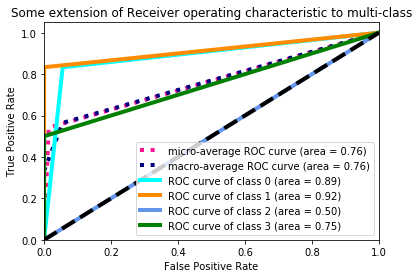

In [9]:
#Use ROC Curve and AUC to evaluate the perfomance of your models
#use for mutliclass classification 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html



# 0 - avocardo
# 1 - pineapple
# 2 - orange 
# 3 - strawberry

# Binarize the output
y_binary = label_binarize(labels,classes=['oranges','avacado','pineapple','strawberries'])
n_classes = y_binary.shape[1]

# splitting dataset into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(projection_X, y_binary,stratify=y_binary,test_size=0.3, random_state=0)

#creating model of type StandardScaler to normalize train and test dataset
scaler = StandardScaler()

#compute mean and standard deviation from X_train to be later used for scaling both X_train_1 and X_test_1
scaler.fit(X_train_1)

#Perform standarization of X_train_1
X_train_1 = scaler.transform(X_train_1)

#Perform standarization of X_test_1
X_test_1 = scaler.transform(X_test_1)

#Predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='rbf',gamma='scale'))

#Fit the model to X_train_1,y_train_1 and predicitng labels for X_test_1 dataset
y_score = classifier.fit(X_train_1,y_train_1).predict(X_test_1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 4
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show();

In [19]:
#use stratify cross validation instead of simple train and test model
cv = StratifiedKFold(n_splits = 5,random_state = 0,shuffle = True)
accuracy_stratify_SVM = cross_val_score(model,projection_X,y.ravel(),cv=cv,scoring='accuracy')
print("Cross Validation Scores for SVM: {}".format(accuracy_stratify_SVM))
print("Mean Accuracy Score for SVM: {}".format(np.mean(accuracy_stratify_SVM)))

Cross Validation Scores for SVM: [0.875 0.875 1.    0.875 0.875]
Mean Accuracy Score for SVM: 0.9


In [11]:
#Take advantage of gridsearch with cross validation in your work


#creating parameters dictionary to be used for GridSearchCV
para = [
        {'svc__kernel':['rbf'],'svc__C':[5,10,20,30],'svc__gamma':[0.0001,0.0005,0.001,0.005]}
       ]

# Initialize SVC model
svc = SVC(gamma ='scale')


# Create pipleline model
model_new = make_pipeline(pca, svc)

#creating desired number of stratified partitions
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

#testing the peformance of different hyperparameters individually using cross validation and selecting the best hyperparamter
grid = GridSearchCV(model_new,param_grid=para,cv=cv,scoring='accuracy')

#Fit the model to train data
grid.fit(X_train,y_train)


#Predict labels for test data
y_pred_new = grid.predict(X_test)

C:\Users\Anurag\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
#Evaluating accuracy of the model using gridsearch with cross validation approach
accuracy_simple_test_train = accuracy_score(y_test,y_pred_new, normalize = True) * 100

print("Accuracy for SVM model using gridsearch with cross validation {0} ".format(accuracy_simple_test_train))

print(classification_report(y_test,y_pred_new))

Accuracy for SVM model using gridsearch with cross validation 91.66666666666666 
              precision    recall  f1-score   support

     avacado       1.00      1.00      1.00         6
     oranges       0.75      1.00      0.86         6
   pineapple       1.00      1.00      1.00         6
strawberries       1.00      0.67      0.80         6

    accuracy                           0.92        24
   macro avg       0.94      0.92      0.91        24
weighted avg       0.94      0.92      0.91        24

